# Stock Prediction

We will train Apple stock price dataset (1-1-2010 to 31-12-2018) using LSTM

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

Using TensorFlow backend.


## Data preprocessing

In [2]:
train_data = pd.read_csv('Apple_Stock_Price_Train.csv')
train_data.head()

,Date,Open,High,Low,Close,Volume
0,1/4/2010,30.490000,30.642857,30.340000,30.572857,123432400
1,1/5/2010,30.657143,30.798571,30.464285,30.625713,150476200
2,1/6/2010,30.625713,30.747143,30.107143,30.138571,138040000
3,1/7/2010,30.250000,30.285715,29.864286,30.082857,119282800
4,1/8/2010,30.042856,30.285715,29.865715,30.282858,111902700


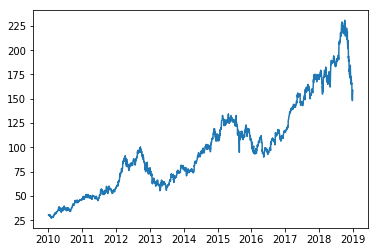

In [3]:
visual_data = pd.read_csv('Apple_Stock_Price_Train.csv',parse_dates=['Date'])
visual_data.set_index('Date',inplace=True)
plt.plot(visual_data['Open'])
plt.show()

In [4]:
train_set = train_data.iloc[:,1:2].values
# Feature scaling
sc = MinMaxScaler(feature_range=(0,1))
train_set_scaled = sc.fit_transform(train_set)

Each month consists of 20 financial days.Here we use 60 past days data to predict the present stock price.

X_train consists of previous 60 days price, while Y_train consist of present day price

In [5]:
X_train = []
Y_train = []

for i in range(60,2264):
    X_train.append(train_set_scaled[i-60:i,0])
    Y_train.append(train_set_scaled[i,0])

X_train,Y_train = np.array(X_train), np.array(Y_train)

# Reshape the data
print(X_train.shape)
X_train = np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(2204, 60)
(2204, 60, 1)


## Build Model

We are going to build 4 LSTM stacked layers with each layer of 50 cells.

In [6]:
regressor = Sequential()

# First layer
regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))

# Second Layer
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

# Third Layer
regressor.add(LSTM(units=50,return_sequences=True))
regressor.add(Dropout(0.2))

# Fourth Layer
regressor.add(LSTM(units=50))
regressor.add(Dropout(0.2))

# Output Layer
regressor.add(Dense(units=1))

regressor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                20200     
__________

In [7]:
regressor.compile(optimizer='adam', loss='mean_squared_error')
regressor.fit(X_train, Y_train, epochs=100, batch_size=32)

Epoch 1/100
2204/2204 [==============================] - 16s 7ms/step - loss: 0.0119
Epoch 2/100
2204/2204 [==============================] - 12s 6ms/step - loss: 0.0026
Epoch 3/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0026
Epoch 4/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0027
Epoch 5/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0023
Epoch 6/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0022
Epoch 7/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0021
Epoch 8/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0019
Epoch 9/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0017
Epoch 10/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0018
Epoch 11/100
2204/2204 [==============================] - 12s 5ms/step - loss: 0.0016
Epoch 12/100
2204/2204 [==============================] - 12s 5

## Predictions

test data(1-1-2019 to 31-1-2019)

In [8]:
test_data = pd.read_csv('Apple_Stock_Price_Test.csv')
real_stock_price = test_data.iloc[:,1:2].values
test_data.head()

,Date,Open,High,Low,Close,Volume
0,1/2/2019,154.889999,158.850006,154.229996,157.919998,37039700
1,1/3/2019,143.979996,145.720001,142.000000,142.190002,91312200
2,1/4/2019,144.529999,148.550003,143.800003,148.259995,58607100
3,1/7/2019,148.699997,148.830002,145.899994,147.929993,54777800
4,1/8/2019,149.559998,151.820007,148.520004,150.750000,41025300


Test input data is previous 60 days

In [9]:
dataset = pd.concat((train_data['Open'],test_data['Open']),axis=0)
inputs = dataset[len(dataset)-len(test_data)-60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test=[]
for i in range(60,80):
    X_test.append(inputs[i-60:i,0])
X_test=np.array(X_test)
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
print(X_test.shape)

(20, 60, 1)


In [10]:
# Predict price and inverse transform predicted price
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

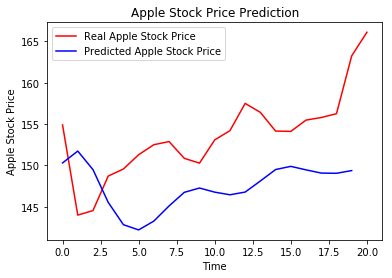

In [11]:
plt.plot(real_stock_price, color = 'red', label = 'Real Apple Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Apple Stock Price')
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Apple Stock Price')
plt.legend()
plt.show()